# Variant Classification: Model Comparison

This notebook compares several classifiers for predicting variant types using different preprocessed datasets. All random processes use a fixed random seed for reproducibility.

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.multiclass import OneVsRestClassifier

RANDOM_SEED = 42

## Data Loading and Preprocessing

Define a function to load and preprocess each dataset. This ensures consistent handling of columns, missing values, splitting, and scaling.

In [12]:
def load_and_preprocess(path, index_col=None, drop_cols=None):
    """
    Loads a CSV file and applies standard preprocessing:
    - Drops specified columns if present.
    - Drops 'Unnamed: 0' if present.
    - Drops 'Mutated' if present (not a target here).
    - Drops non-numeric columns (e.g., ModelID).
    - Splits into train/test and scales features.
    Returns: (X_train_scaled, X_test_scaled, y_train, y_test, feature_names)
    """
    df = pd.read_csv(path, index_col=index_col)
    if drop_cols:
        df = df.drop(columns=drop_cols, errors='ignore')
    df = df.drop(columns=['Unnamed: 0'], errors='ignore')
    df = df.drop(columns=['Mutated'], errors='ignore')
    # Remove rows where VariantType == 0, if the column exists
    if 'VariantType' in df.columns:
        df = df[df['VariantType'] != 0]
        df.VariantType  = df.VariantType - 1
    
    # Separate target before selecting numeric features
    target = df['VariantType']
    features = df.drop(columns=['VariantType'], errors='ignore')
    # Keep only numeric features
    features = features.select_dtypes(include=[np.number])
    X_train, X_test, y_train, y_test = train_test_split(
        features, target, test_size=0.2, random_state=RANDOM_SEED, stratify=target
    )
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    return X_train_scaled, X_test_scaled, y_train, y_test, features.columns

## Prepare Datasets

Load all datasets and store them in a list for easy iteration. Each entry contains scaled train/test splits and feature names.

In [13]:
dataset_paths = [
    ('../data/processed/ccle/ccle_quantile_filtered.csv', None, 'Quantile Filtered'),
    ('../data/processed/ccle/ccle_tp53_filtered.csv', None, 'TP53 Filtered'),
    ('../data/processed/ccle/ccle_variance_filtered.csv', None, 'Variance Filtered'),
    ('../data/processed/ccle/merged_data.csv', 1, 'Not Filtered'),
]
drop_cols = ['VariantLabel']

datasets = []
dataset_names = []
for path, idx_col, name in dataset_paths:
    X_train, X_test, y_train, y_test, feature_names = load_and_preprocess(path, index_col=idx_col, drop_cols=drop_cols)
    datasets.append((X_train, X_test, y_train, y_test, feature_names))
    dataset_names.append(name)

## Model Training and Evaluation Function

This function trains and evaluates a given model on each dataset, displaying accuracy, F1 score, confusion matrix, and feature importance.

In [14]:
def train_and_evaluate_on_datasets(datasets, model_name, dataset_names=None):
    from sklearn.metrics import roc_auc_score
    base_model_map = {
        'logistic': LogisticRegression(max_iter=1000, solver='lbfgs', random_state=RANDOM_SEED),
        'svm': SVC(kernel='rbf', probability=True, decision_function_shape='ovr', random_state=RANDOM_SEED),
        'random_forest': RandomForestClassifier(random_state=RANDOM_SEED),
        'xgboost': XGBClassifier(eval_metric='mlogloss', random_state=RANDOM_SEED),
    }

    if model_name not in base_model_map:
        raise ValueError(f"Unsupported model: {model_name}")

    # Wrap logistic in One-vs-Rest
    if model_name == 'logistic':
        model = OneVsRestClassifier(base_model_map['logistic'])
    else:
        model = base_model_map[model_name]

    num_datasets = len(datasets)
    if dataset_names is None:
        dataset_names = [f"Dataset {i+1}" for i in range(num_datasets)]
    fig, axes = plt.subplots(nrows=num_datasets, ncols=2, figsize=(12, 5 * num_datasets))
    if num_datasets == 1:
        axes = [axes]

    for idx, (X_train, X_test, y_train, y_test, feature_names) in enumerate(datasets):
        dataset_title = dataset_names[idx] if idx < len(dataset_names) else f"Dataset {idx+1}"
        # Train the model
        if model_name in ['catboost', 'xgboost']:
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            if hasattr(model, "predict_proba"):
                y_proba = model.predict_proba(X_test)
            else:
                y_proba = None
        else:
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            if hasattr(model, "predict_proba"):
                y_proba = model.predict_proba(X_test)
            else:
                y_proba = None

        acc = accuracy_score(y_test, y_pred)
        f1 = classification_report(y_test, y_pred, output_dict=True, zero_division=0)['weighted avg']['f1-score']
        auc = None
        # AUC for multiclass: use 'ovr' if >2 classes, else binary
        if y_proba is not None:
            try:
                if y_proba.shape[1] == 2:
                    auc = roc_auc_score(y_test, y_proba[:, 1])
                else:
                    auc = roc_auc_score(y_test, y_proba, multi_class='ovr')
            except Exception:
                auc = None
        if auc is not None:
            print(f"{dataset_title} - Accuracy: {acc:.2f} - F1 Score: {f1:.2f} - AUC: {auc:.2f} - Model: {model_name}")
        else:
            print(f"{dataset_title} - Accuracy: {acc:.2f} - F1 Score: {f1:.2f} - Model: {model_name}")

        # Confusion matrix
        cm = confusion_matrix(y_test, y_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx][0])
        axes[idx][0].set_title(f'{dataset_title} - Confusion Matrix')
        axes[idx][0].set_xlabel('Predicted')
        axes[idx][0].set_ylabel('True')

        # Feature importance
        if model_name in ['random_forest', 'catboost', 'xgboost']:
            importances = model.feature_importances_
        elif model_name == 'svm':
            if hasattr(model, 'coef_'):
                importances = np.abs(model.coef_).sum(axis=0)
            else:
                axes[idx][1].axis('off')
                continue
        elif model_name == 'logistic':
            if hasattr(model, 'estimators_'):
                all_coefs = np.array([np.abs(est.coef_).flatten() for est in model.estimators_])
                importances = all_coefs.sum(axis=0)
            else:
                axes[idx][1].axis('off')
                continue
        else:
            axes[idx][1].axis('off')
            continue

        indices = np.argsort(importances)[::-1][:10]
        top_features = feature_names[indices]
        sns.barplot(x=importances[indices], y=top_features, ax=axes[idx][1])
        axes[idx][1].set_title(f'{dataset_title} - Feature Importance')

    plt.tight_layout()
    plt.show()

# Random baseline

In [15]:
from sklearn.dummy import DummyClassifier
def random_baseline(X_train, X_test, y_train, y_test):
    dummy = DummyClassifier(strategy="uniform", random_state=RANDOM_SEED)
    dummy.fit(X_train, y_train)
    y_pred = dummy.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    f1 = classification_report(y_test, y_pred, output_dict=True, zero_division=0)['weighted avg']['f1-score']
    print(f"Random Baseline - Accuracy: {acc:.4f} - F1 Score: {f1:.4f}")

def majority_baseline(X_train, X_test, y_train, y_test):
    dummy = DummyClassifier(strategy="most_frequent", random_state=RANDOM_SEED)
    dummy.fit(X_train, y_train)
    y_pred = dummy.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    f1 = classification_report(y_test, y_pred, output_dict=True, zero_division=0)['weighted avg']['f1-score']
    print(f"Majority Baseline - Accuracy: {acc:.4f} - F1 Score: {f1:.4f}")

# Evaluate random and majority baselines
print("Evaluating Random Baseline:")
random_baseline(X_train, X_test, y_train, y_test)
print("Evaluating Majority Baseline:")
majority_baseline(X_train, X_test, y_train, y_test)

Evaluating Random Baseline:
Random Baseline - Accuracy: 0.2254 - F1 Score: 0.2884
Evaluating Majority Baseline:
Majority Baseline - Accuracy: 0.7977 - F1 Score: 0.7079


## Logistic Regression (One-vs-Rest)

Quantile Filtered - Accuracy: 0.82 - F1 Score: 0.78 - AUC: 0.79 - Model: logistic
TP53 Filtered - Accuracy: 0.84 - F1 Score: 0.83 - AUC: 0.83 - Model: logistic
Variance Filtered - Accuracy: 0.82 - F1 Score: 0.79 - AUC: 0.80 - Model: logistic
Not Filtered - Accuracy: 0.83 - F1 Score: 0.81 - AUC: 0.77 - Model: logistic


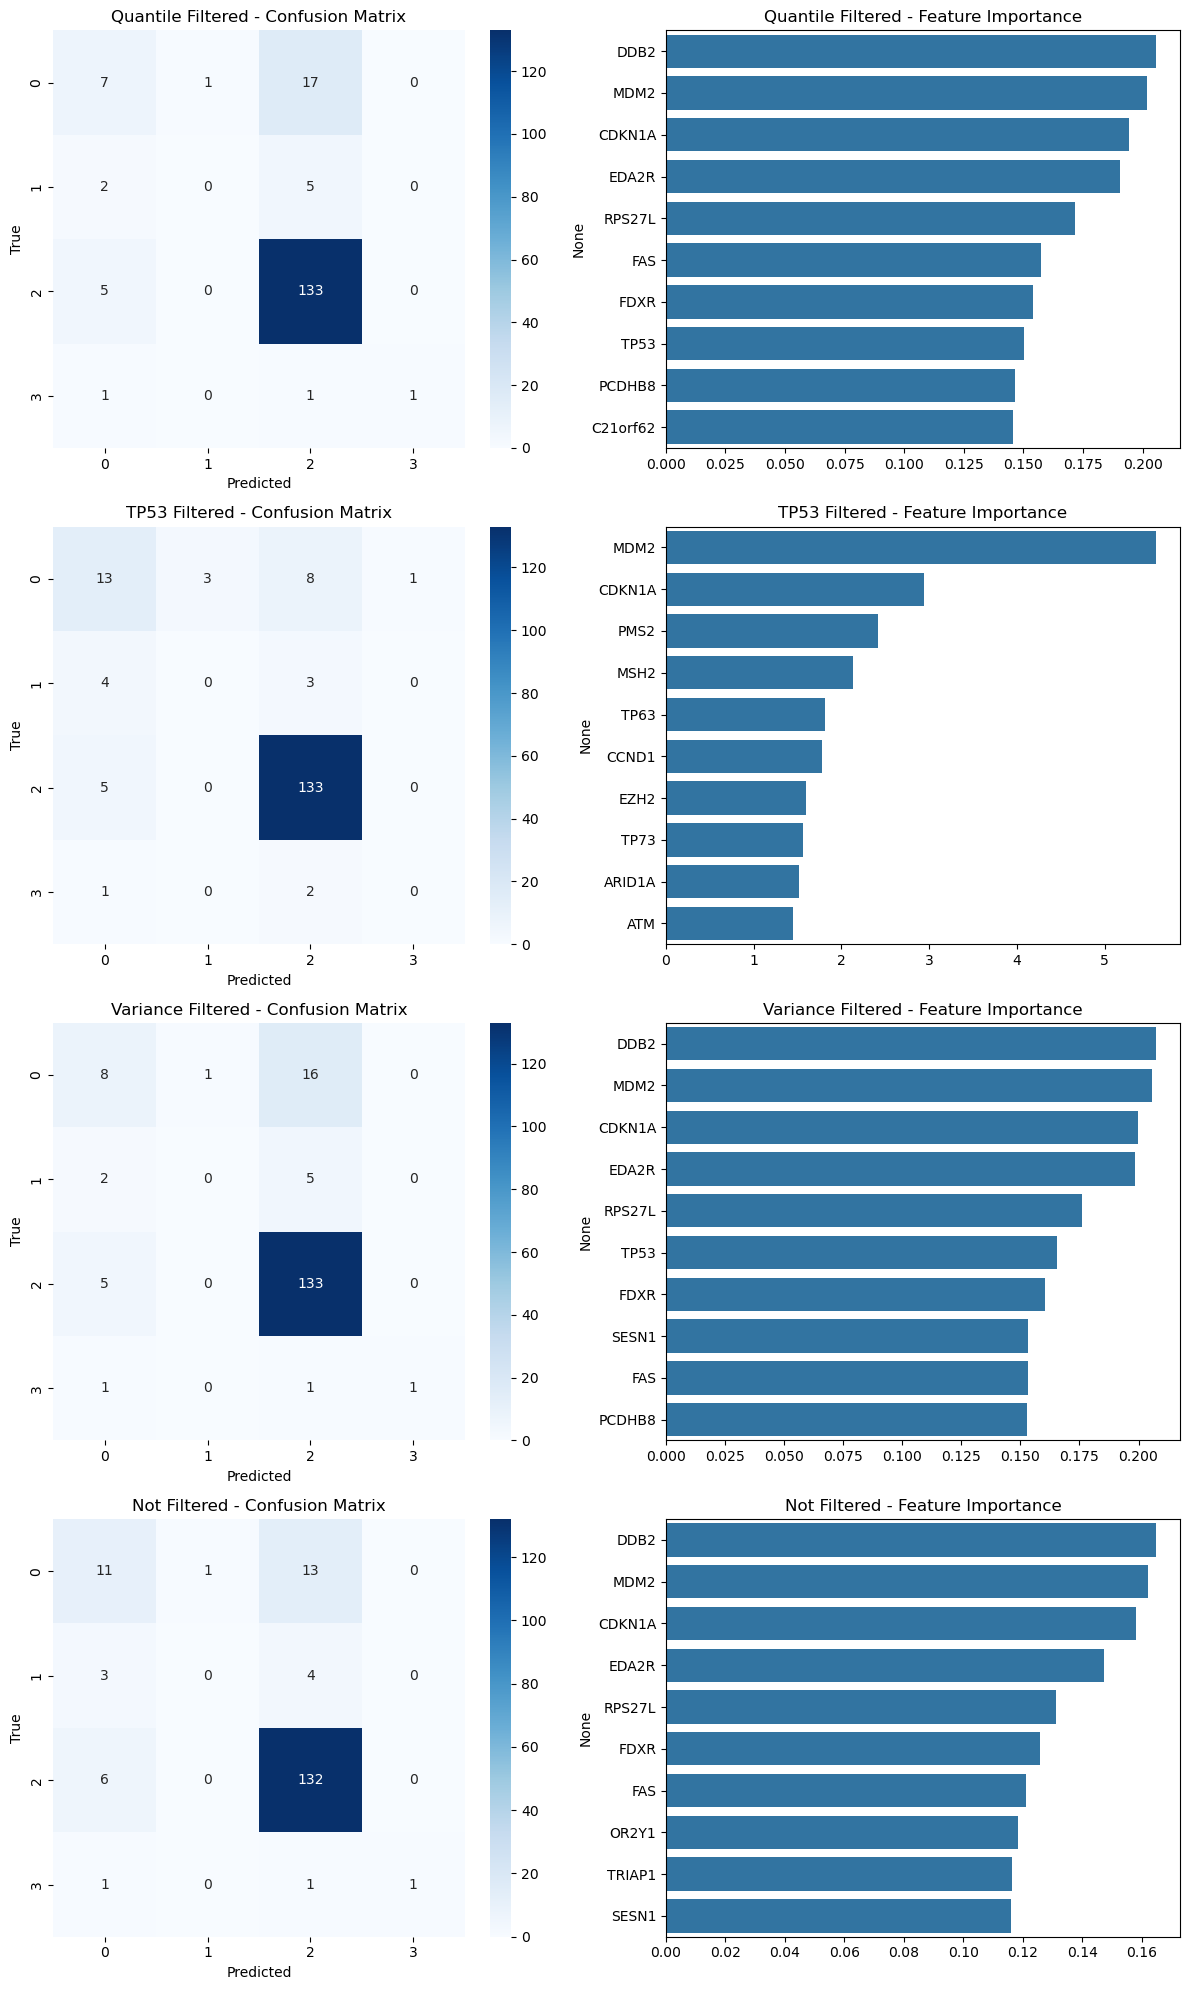

In [16]:
train_and_evaluate_on_datasets(datasets, 'logistic', dataset_names=dataset_names)

## Support Vector Machine (SVM)

Quantile Filtered - Accuracy: 0.81 - F1 Score: 0.73 - AUC: 0.79 - Model: svm
TP53 Filtered - Accuracy: 0.82 - F1 Score: 0.75 - AUC: 0.86 - Model: svm
Variance Filtered - Accuracy: 0.80 - F1 Score: 0.72 - AUC: 0.79 - Model: svm
Not Filtered - Accuracy: 0.80 - F1 Score: 0.72 - AUC: 0.78 - Model: svm


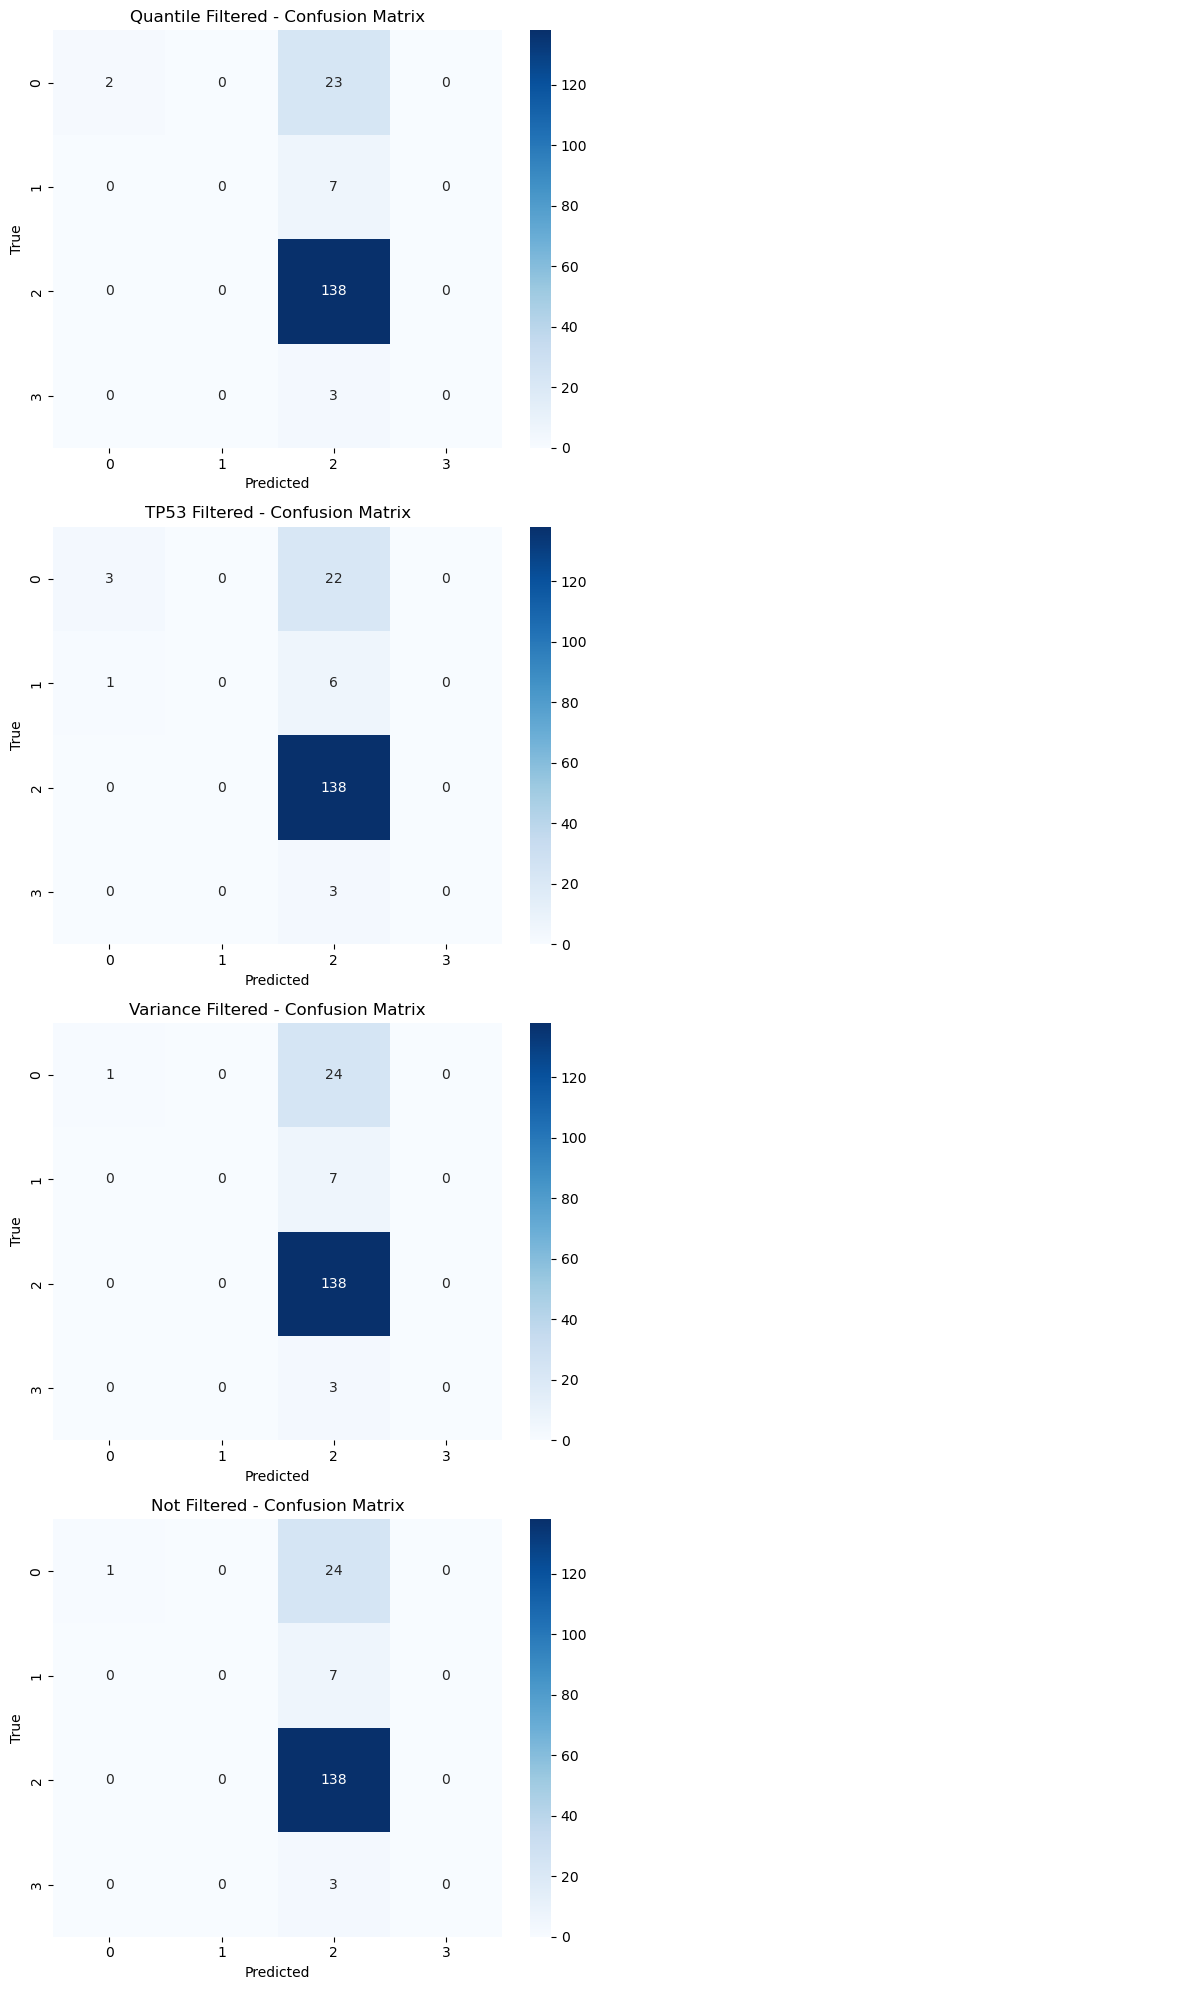

In [17]:
train_and_evaluate_on_datasets(datasets, 'svm', dataset_names=dataset_names)

## Random Forest

Quantile Filtered - Accuracy: 0.82 - F1 Score: 0.75 - AUC: 0.72 - Model: random_forest
TP53 Filtered - Accuracy: 0.83 - F1 Score: 0.79 - AUC: 0.82 - Model: random_forest
Variance Filtered - Accuracy: 0.82 - F1 Score: 0.75 - AUC: 0.82 - Model: random_forest
Not Filtered - Accuracy: 0.82 - F1 Score: 0.76 - AUC: 0.77 - Model: random_forest


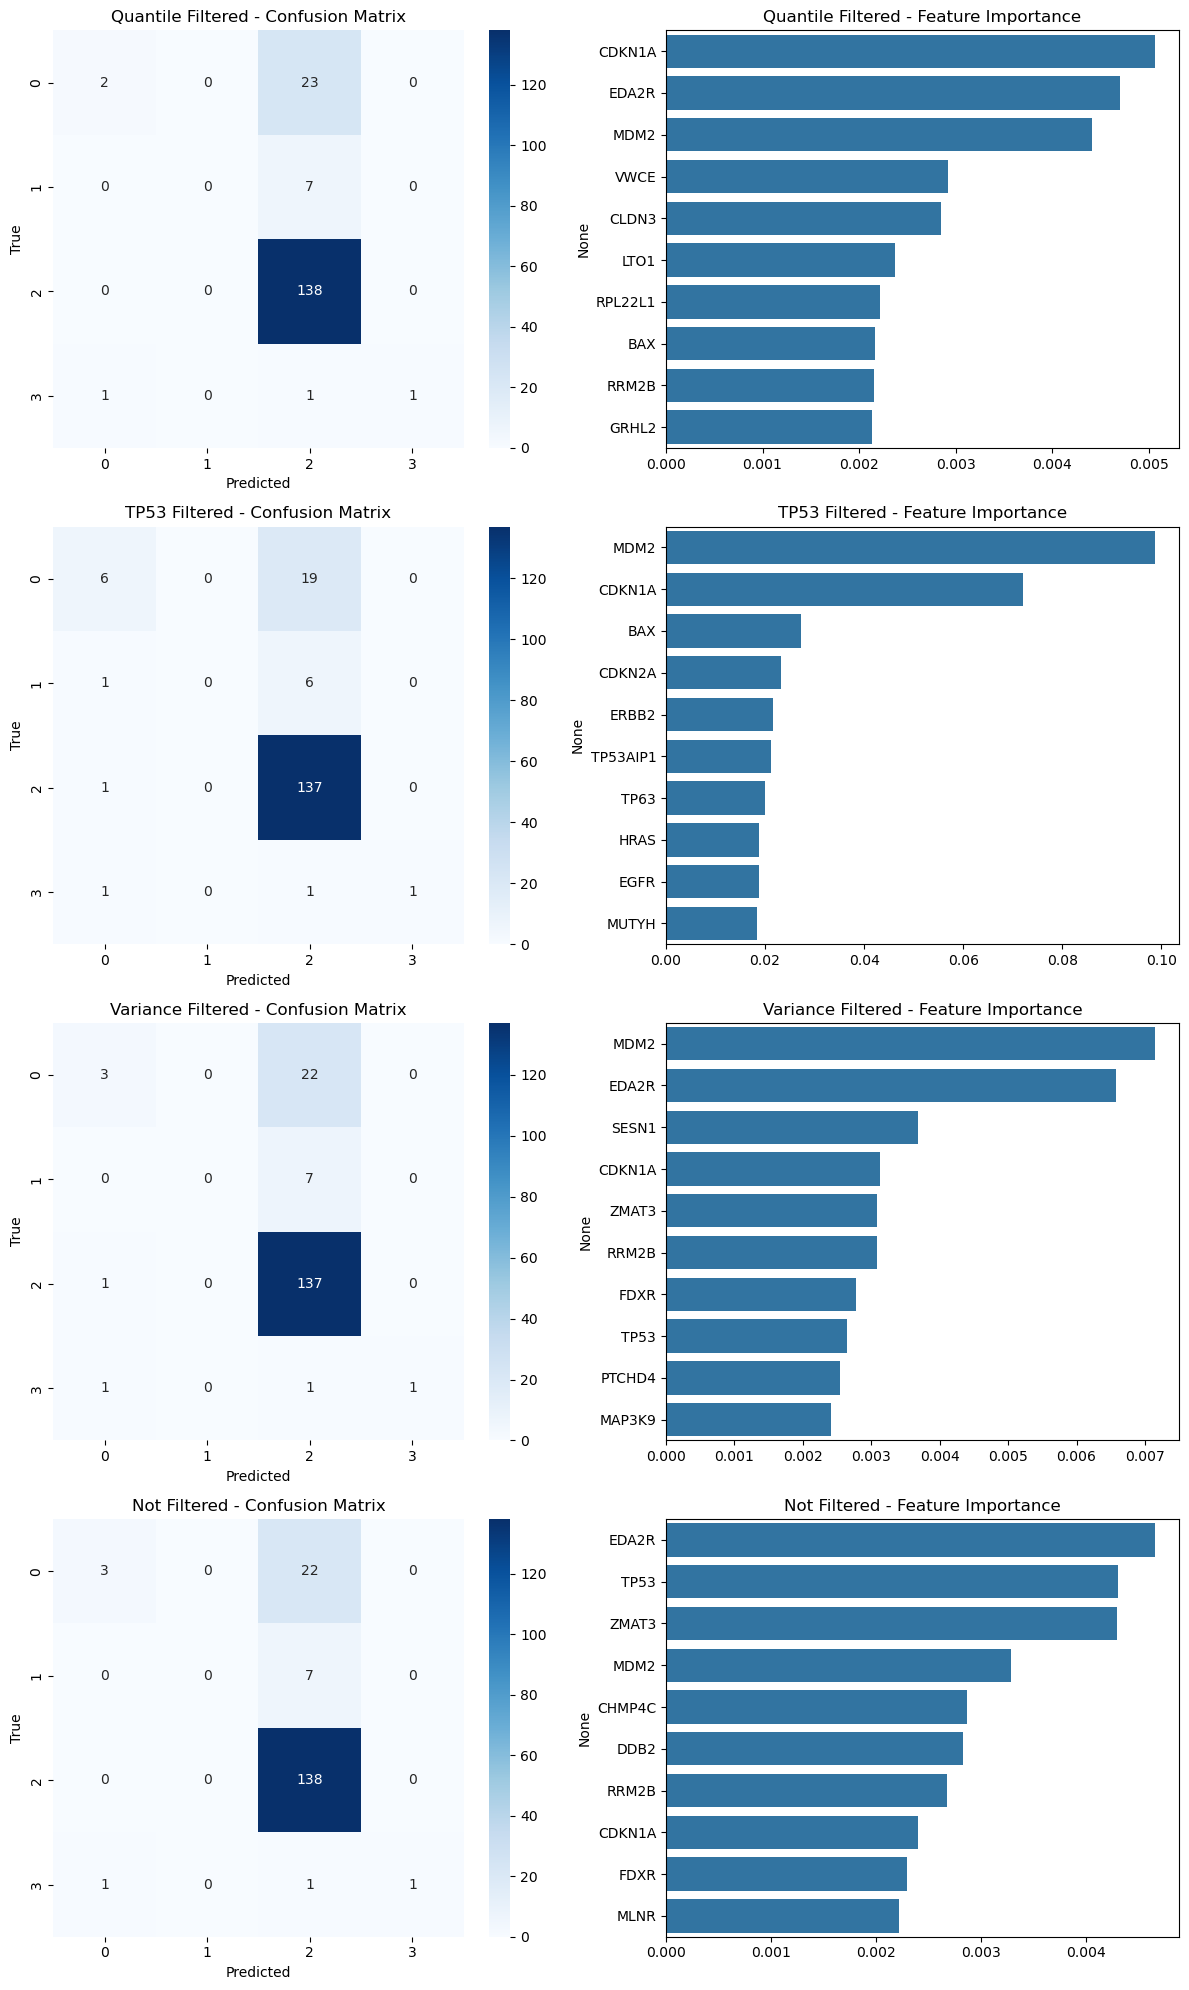

In [18]:
train_and_evaluate_on_datasets(datasets, 'random_forest', dataset_names=dataset_names)

## XGBoost

Quantile Filtered - Accuracy: 0.83 - F1 Score: 0.79 - AUC: 0.87 - Model: xgboost
TP53 Filtered - Accuracy: 0.85 - F1 Score: 0.83 - AUC: 0.85 - Model: xgboost
Variance Filtered - Accuracy: 0.84 - F1 Score: 0.82 - AUC: 0.86 - Model: xgboost
Not Filtered - Accuracy: 0.84 - F1 Score: 0.81 - AUC: 0.86 - Model: xgboost


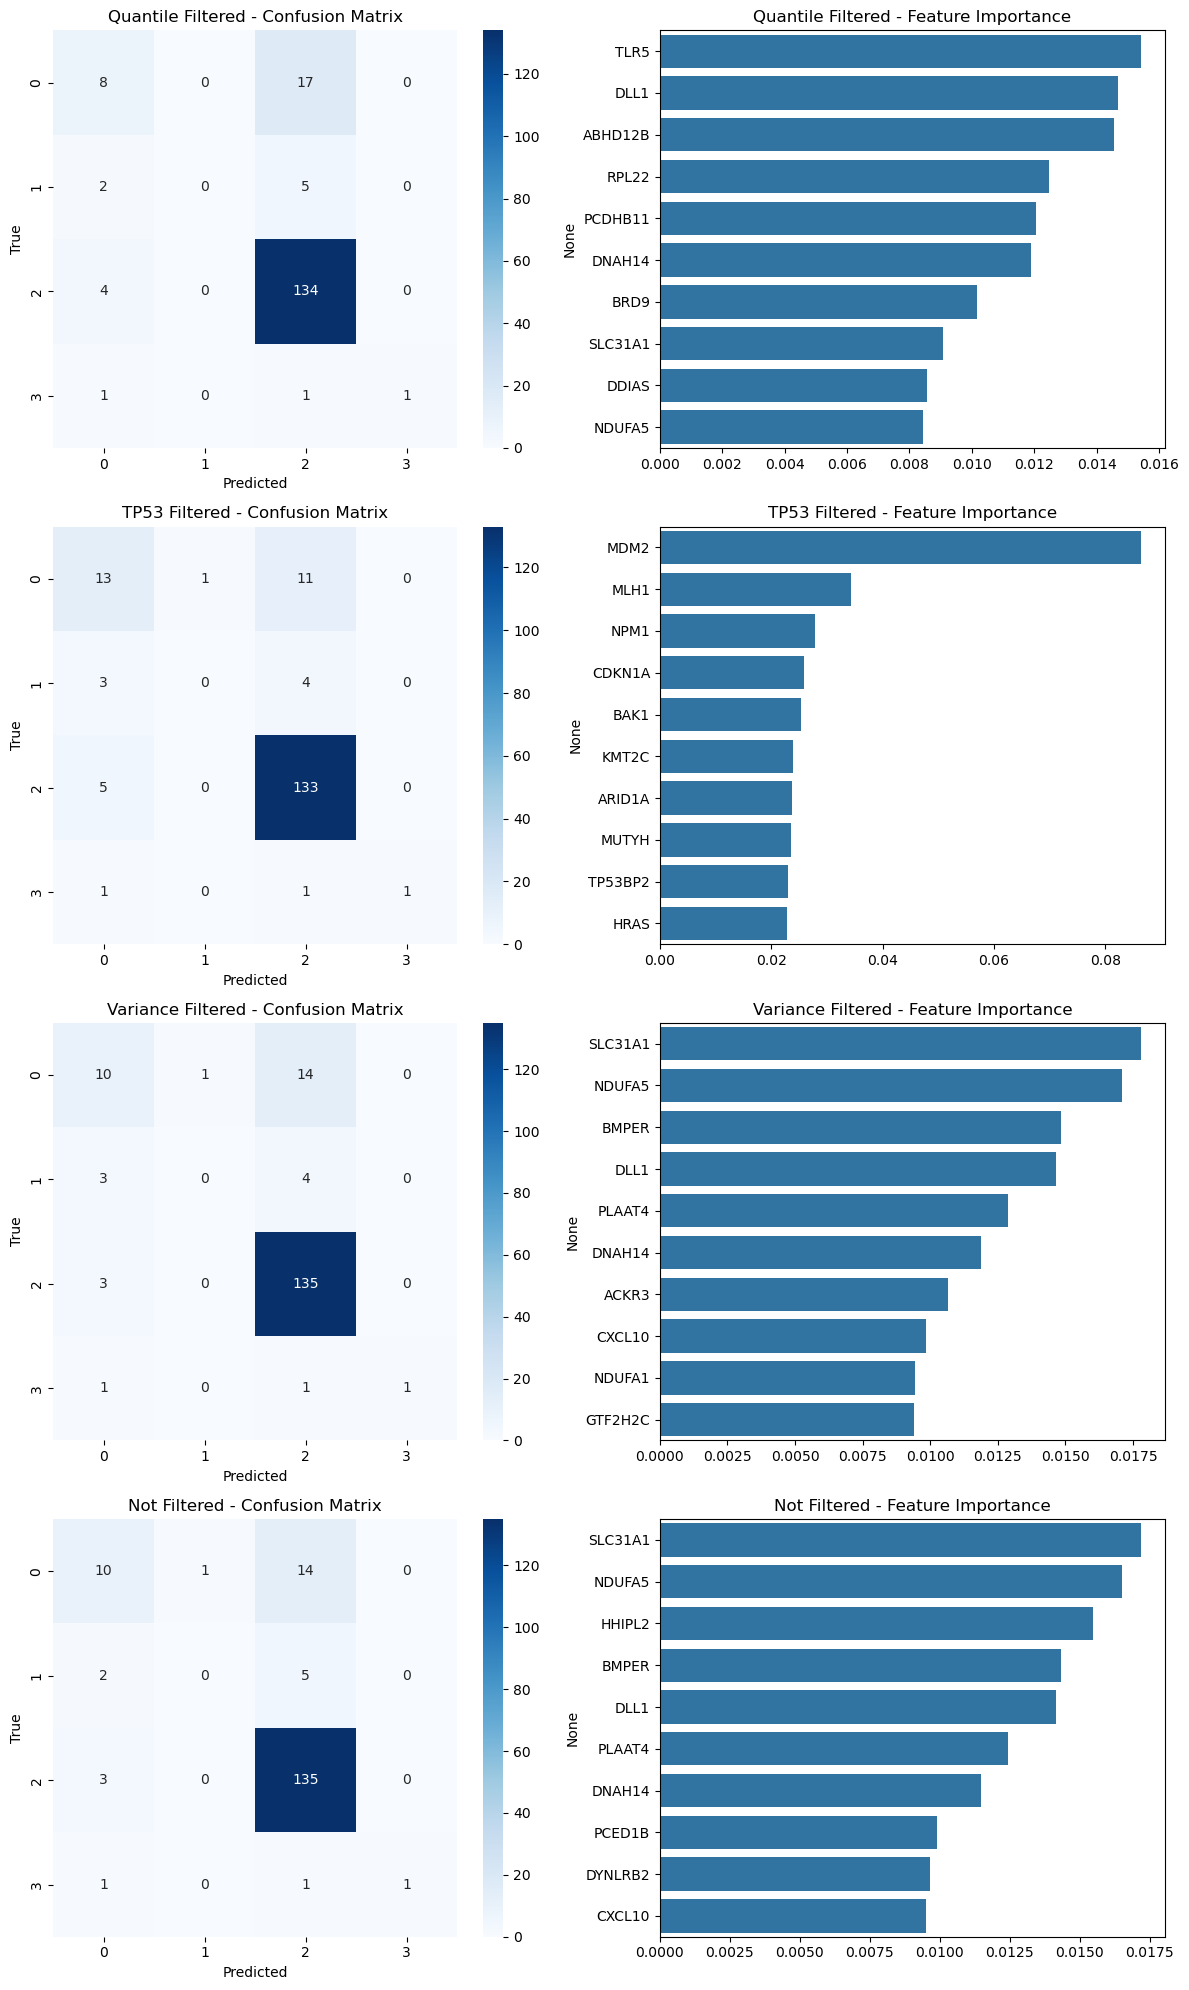

In [19]:
train_and_evaluate_on_datasets(datasets, 'xgboost', dataset_names=dataset_names)

## Random Oversampling and SMOTE on TP53 Filtered Dataset (XGBoost)

We apply Random Oversampling and SMOTE to the TP53 filtered dataset and evaluate with XGBoost. Performance does not change much compared to the original, indicating that class imbalance is not a major issue for this task.

In [20]:
from imblearn.over_sampling import RandomOverSampler, SMOTE

# Select TP53 filtered dataset (second in the list)
X_train_tp53, X_test_tp53, y_train_tp53, y_test_tp53, feature_names_tp53 = datasets[1]

# Random Oversampling
ros = RandomOverSampler(random_state=RANDOM_SEED)
X_train_ros, y_train_ros = ros.fit_resample(X_train_tp53, y_train_tp53)
print("Random Oversampling (TP53, XGBoost):")
xgb_ros = XGBClassifier(eval_metric='mlogloss', random_state=RANDOM_SEED)
xgb_ros.fit(X_train_ros, y_train_ros)
y_pred_ros = xgb_ros.predict(X_test_tp53)
acc_ros = accuracy_score(y_test_tp53, y_pred_ros)
f1_ros = classification_report(y_test_tp53, y_pred_ros, output_dict=True, zero_division=0)['weighted avg']['f1-score']
print(f"Accuracy: {acc_ros:.4f} - F1 Score: {f1_ros:.4f}")

# SMOTE
smote = SMOTE(random_state=RANDOM_SEED)
X_train_smote, y_train_smote = smote.fit_resample(X_train_tp53, y_train_tp53)
print("SMOTE (TP53, XGBoost):")
xgb_smote = XGBClassifier(eval_metric='mlogloss', random_state=RANDOM_SEED)
xgb_smote.fit(X_train_smote, y_train_smote)
y_pred_smote = xgb_smote.predict(X_test_tp53)
acc_smote = accuracy_score(y_test_tp53, y_pred_smote)
f1_smote = classification_report(y_test_tp53, y_pred_smote, output_dict=True, zero_division=0)['weighted avg']['f1-score']
print(f"Accuracy: {acc_smote:.4f} - F1 Score: {f1_smote:.4f}")

Random Oversampling (TP53, XGBoost):
Accuracy: 0.8613 - F1 Score: 0.8396
SMOTE (TP53, XGBoost):
Accuracy: 0.8497 - F1 Score: 0.8339


Performance with both Random Oversampling and SMOTE is very similar to the original XGBoost results, confirming that oversampling does not significantly impact the model for this dataset.